# Image Classification Project - José Pereira


## Setup

Es wird das Paketverwaltungstool 'pip' für Python verwendet, um das TensorFlow-Paket zu verwalten.
Der '!' wird in Jupyter-Notebooks verwendet, um Systembefehle auszuführen.

Die erforderlichen Python-Bibliotheken und -Module für maschinelles Lernen werden importiert, insbesondere TensorFlow, NumPy, Keras, TensorFlow Datasets und Matplotlib, und gibt die installierte TensorFlow-Version aus.

In [26]:
# Der folgende Befehl wird verwendet, um TensorFlow zu installieren oder auf die neueste Version zu aktualisieren.
!pip install --upgrade tensorflow

# Installiert das tensorflow_datasets-Paket.
!pip install tensorflow_datasets

# Installiert das matplotlib-Paket.
!pip install matplotlib

# Der folgende Befehl wird verwendet, um das setuptools-Paket zu installieren oder auf die neueste Version zu aktualisieren.
!pip install setuptools

In [27]:
# Importiert das TensorFlow-Paket, eine Bibliothek für maschinelles Lernen.
import tensorflow as tf

# Importiert NumPy, eine Bibliothek für numerische Berechnungen.
import numpy as np

# Importiert Keras, eine benutzerfreundliche API für das Erstellen und Trainieren von Deep-Learning-Modellen.
import keras
from keras import layers  # Importiert die layers-Komponente von Keras, um neuronale Netzwerkschichten zu definieren.

# Importiert tensorflow_datasets, eine Sammlung von gängigen Datensätzen für maschinelles Lernen.
import tensorflow_datasets as tfds

# Importiert matplotlib.pyplot, eine Bibliothek für das Erstellen von Visualisierungen und Diagrammen.
import matplotlib.pyplot as plt

# Gibt die aktuell installierte Version von TensorFlow aus.
print(tf.__version__)


2.16.1


## Image classification model on a brain tumor dataset

### Getting the data
Dataset from: https://www.kaggle.com/datasets/abhranta/brain-tumor-detection-mri

FYI: Der Ordner pred wurde nicht übernommen.


### Datensatzvorbereitung:

Dieser Code lädt einen Bilddatensatz für die Klassifizierung von Hirntumoren aus dem Verzeichnis 'tumor' und teilt ihn in Trainings- und Validierungsdatensätze auf. Die Bilder werden auf eine Größe von 256x256 Pixeln skaliert, in Batches von 32 Bildern geladen, und 20% der Daten werden für die Validierung verwendet. Die Datensätze werden zufällig gemischt, um eine bessere Generalisierung während des Trainings zu ermöglichen.

- directory='Data': Das Verzeichnis, aus dem die Bilder geladen werden. In diesem Fall ist das Verzeichnis "Tumor".
- labels='inferred': Die Labels (Kategorien) werden aus den Unterverzeichnissen des angegebenen Verzeichnisses abgeleitet. Jedes Unterverzeichnis wird als eine Klasse betrachtet.
- label_mode='int': Die Labels werden als ganze Zahlen (Integer) kodiert.
- validation_split=0.2: 20% der Daten werden für die Validierung verwendet, während die restlichen 80% für das Training verwendet werden.
- subset="both": Es werden sowohl Trainings- als auch Validierungsdatensätze erstellt.
- seed=42: Ein Zufallsseed, um die Aufteilung der Daten zwischen Training und Validierung reproduzierbar zu machen.
- batch_size=32: Die Größe der Batches, in denen die Daten geladen werden. In diesem Fall werden 32 Bilder pro Batch geladen.
- image_size=(256,256): Die Größe, auf die die Bilder skaliert werden. Alle Bilder werden auf 256x256 Pixel skaliert.
- interpolation="nearest": Die Methode der Interpolation, die verwendet wird, um die Bilder auf die gewünschte Größe zu skalieren. In diesem Fall ist es die "nearest neighbor"-Interpolation.
- shuffle=True: Die Daten werden vor jedem Trainingsepoch zufällig gemischt.

In [28]:
# Lädt Bilder aus dem angegebenen Verzeichnis 'tumor' und erstellt Trainings- und Validierungsdatensätze.
train_ds, validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory='tumor',          # Pfad zum Verzeichnis, das die Bilder enthält.
    labels='inferred',          # Labels werden aus den Verzeichnisnamen abgeleitet.
    label_mode='int',           # Labels werden als Ganzzahlen dargestellt.
    validation_split=0.2,       # 20% der Daten werden für die Validierung verwendet.
    subset="both",              # Erstellt sowohl Trainings- als auch Validierungsdatensätze.
    seed=42,                    # Zufallszahlengenerator-Saatgut für reproduzierbare Ergebnisse.
    batch_size=32,              # Anzahl der Bilder pro Batch.
    image_size=(256, 256),      # Größe, auf die die Bilder skaliert werden.
    interpolation="nearest",    # Interpolationsmethode zur Größenänderung der Bilder.
    shuffle=True                # Bilder werden zufällig gemischt, um die Trainingsdaten zu durchmischen.
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Using 600 files for validation.


Dieser Code teilt den ursprünglichen Validierungsdatensatz in zwei Hälften auf - eine Hälfte wird als neuer Validierungsdatensatz verwendet und die andere Hälfte als separater Testdatensatz.

- val_bs ist wie das Zählen von Päckchen mit Karten in einem Kartenspiel. Es sagt uns, wie viele Stapel (oder Gruppen) von Bildern im Validierungsdatensatz sind.
- test_ds nimmt die erste Hälfte der Stapel. Wenn wir zum Beispiel 10 Stapel haben, nehmen wir die ersten 5 Stapel und nennen sie test_ds.
- validation_ds überspringt die erste Hälfte und behält die zweite Hälfte. Wenn wir wieder 10 Stapel haben, überspringen wir die ersten 5 Stapel und behalten die letzten 5 Stapel.

Anschliessend gibt er die Anzahl der Batches in den Trainings-, Validierungs- und Testdatensätzen aus.

- "Number of training batches: 75" bedeutet, dass der Stapel, den du zum Üben verwendest, in 75 Gruppen aufgeteilt ist. Du hast also 75 Gruppen von Karten, mit denen du üben kannst.
- "Number of validation batches: 10" bedeutet, dass der Stapel, den du während des Übens zur Überprüfung verwendest, in 10 Gruppen aufgeteilt ist. Du hast also 10 Gruppen von Karten, mit denen du überprüfen kannst, wie gut du beim Üben bist.
- "Number of test batches: 9" bedeutet, dass der Stapel, den du am Ende verwendest, um zu sehen, wie gut du wirklich bist, in 9 Gruppen aufgeteilt ist. Du hast also 9 Gruppen von Karten, mit denen du deine endgültigen Fähigkeiten testen kannst.

3000 Daten / 32 Batch_size = 93.75 (94 Batches)

In [29]:
# Bestimmt die Anzahl der Batches im Validierungsdatensatz.
val_batches = tf.data.experimental.cardinality(validation_ds).numpy()
# Nimmt 50% der Batches aus dem Validierungsdatensatz und weist sie dem Testdatensatz zu.
test_ds = validation_ds.take(val_batches // 2)
# Überspringt 50% der Batches im Validierungsdatensatz, um den verbleibenden Teil als neuen Validierungsdatensatz zu verwenden.
validation_ds = validation_ds.skip(val_batches // 2)

# Gibt die Anzahl der Trainings-Batches aus.
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds).numpy())
# Gibt die Anzahl der Validierungs-Batches aus.
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds).numpy())
# Gibt die Anzahl der Test-Batches aus.
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds).numpy())




Number of training batches: 75
Number of validation batches: 10
Number of test batches: 9


Der Zweck dieses Codes ist es, eine Vorschau der Bilder im Trainingsdatensatz anzuzeigen. Die ersten 9 Bilder des ersten Batches werden in einem 3x3-Raster mit den entsprechenden Klassennamen als Titel dargestellt. Dies ist nützlich, um visuell zu überprüfen, ob die Bilder korrekt geladen wurden und die Klassennamen korrekt zugeordnet sind.

- class_names ist eine Liste, die uns die Namen der Klassen (Kategorien) gibt, zum Beispiel ["tumor", "non_tumor"]. Diese Liste sagt uns, welche Namen wir den Bildern geben sollen.

- plt.figure(figsize=(10, 10)) erstellt eine neue große Fläche (wie ein großes Poster), auf der wir die Bilder zeigen können. Die Fläche ist 10x10 Einheiten groß.

- train_ds.take(1) nimmt eine Gruppe (Batch) von Bildern aus dem Trainingsdatensatz. Jede Gruppe hat mehrere Bilder und die dazugehörigen Labels (Tumor oder Nicht-Tumor).

- for i in range(9): Diese Schleife läuft 9 Mal, damit wir 9 Bilder anzeigen können.
- ax = plt.subplot(3, 3, i + 1): Diese Zeile erstellt ein kleines Kästchen (eine Unterfläche) in unserem großen Poster. Es gibt insgesamt 9 Kästchen, angeordnet in 3 Reihen und 3 Spalten.
- plt.imshow(images[i].numpy().astype("uint8")): Diese Zeile zeigt das Bild im Kästchen an. Jedes Bild wird in eine Form gebracht, die der Computer anzeigen kann.
- plt.title(class_names[labels[i]]): Diese Zeile gibt dem Bild eine Überschrift, die entweder "tumor" oder "non_tumor" ist, je nachdem, was das Label sagt.
- plt.axis("off"): Diese Zeile entfernt die Achsen um das Bild, damit es sauberer aussieht.

Anzahl Klassen im Trainingsdatensatz berechnen:
- train_ds.class_names gibt uns eine Liste mit den Namen aller verschiedenen Kategorien (Klassen) in unserem Trainingsdatensatz. Zum Beispiel könnte die Liste so aussehen: ["tumor", "non_tumor"].
- len() ist wie das Zählen der Anzahl von Dingen in einer Liste. Es sagt uns, wie viele verschiedene Kategorien in der Liste sind.

- number_of_classes ist die Anzahl der verschiedenen Kategorien (Klassen) in unserem Trainingsdatensatz.



Anzahl der Klassen im Trainingsdatensatz: 2


2024-06-05 13:56:50.153255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


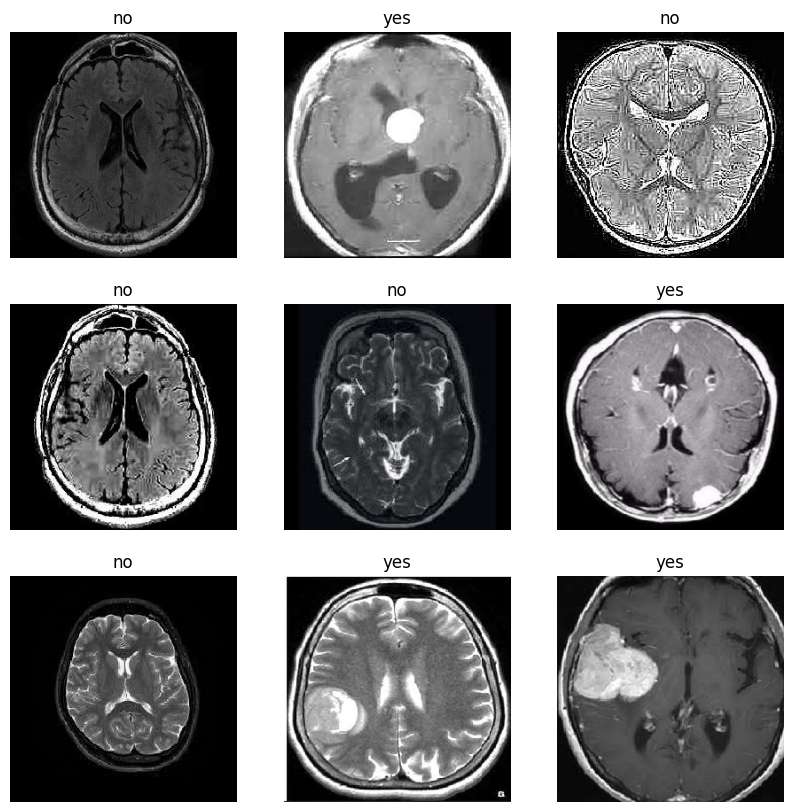

In [30]:
# Holt die Klassennamen aus dem Trainingsdatensatz.
class_names = train_ds.class_names

# Erstellt eine neue Abbildung mit einer Größe von 10x10 Zoll.
plt.figure(figsize=(10, 10))

# Nimmt ein Batch von Bildern und Labels aus dem Trainingsdatensatz.
for images, labels in train_ds.take(1):
  # Zeigt die ersten 9 Bilder im Batch an.
  for i in range(9):
    # Erstellt ein neues Subplot im 3x3-Raster.
    ax = plt.subplot(3, 3, i + 1)
    # Zeigt das Bild an. Die Bilder werden in NumPy-Arrays konvertiert und als 8-Bit-Unsigned-Integer dargestellt.
    plt.imshow(images[i].numpy().astype("uint8"))
    # Setzt den Titel des Subplots auf den entsprechenden Klassennamen.
    plt.title(class_names[labels[i]])
    # Entfernt die Achsenbeschriftungen.
    plt.axis("off")

# Berechnet die Anzahl der Klassen im Trainingsdatensatz.
number_of_classes = len(train_ds.class_names)
# Gibt die Anzahl der Klassen im Trainingsdatensatz aus.
print("Anzahl der Klassen im Trainingsdatensatz:", number_of_classes)

### Standardizing the data


Unsere Rohbilder haben eine Vielzahl von Größen. Zusätzlich besteht jeder Pixel aus 3 ganzen Zahlen zwischen 0 und 255 (RGB-Werten). Dies ist keine optimale Vorbereitung für die Eingabe in ein neuronales Netzwerk. Wir müssen zwei Dinge tun:

- Standardisierung auf eine feste Bildgröße. Wir wählen 150x150.
- Normalisierung der Pixelwerte zwischen -1 und 1. Dies werden wir mit einer Normalization-Schicht als Teil des Modells selbst durchführen.

Dieser Code importiert die Resizing-Schicht aus Keras und wendet sie auf die Trainings-, Validierungs- und Testdatensätze an, um die Bildgrößen auf 150x150 Pixel zu skalieren. Dies ist ein wichtiger Vorverarbeitungsschritt, da neuronale Netzwerke Eingaben fester Größe benötigen.

- resize_fn ist wie ein magisches Werkzeug, das alle Bilder auf eine Größe von 150x150 Pixeln verkleinern oder vergrößern kann.
- train_ds.map(lambda x, y: (resize_fn(x), y)) nimmt jedes Bild im Trainingsdatensatz (x) und ändert seine Größe auf 150x150 Pixel. Das Label (y), das sagt, ob das Bild einen Tumor hat oder nicht, bleibt unverändert.
- Das Gleiche passiert mit dem Validierungsdatensatz. Jedes Bild wird auf 150x150 Pixel geändert, und die Labels bleiben gleich.
- Auch hier wird jedes Bild im Testdatensatz auf 150x150 Pixel geändert, und die Labels bleiben gleich.

In [31]:
# Importieren der Resizing-Schicht aus Keras
resize_fn = keras.layers.Resizing(150, 150)

# Anwenden der Resizing-Schicht auf den Trainingsdatensatz
train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))

# Anwenden der Resizing-Schicht auf den Validierungsdatensatz
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))

# Anwenden der Resizing-Schicht auf den Testdatensatz
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))


### Data augmentation


Dieser Code definiert Datenaugmentierungsschichten für zufälliges horizontales Spiegeln, Veränderung der Helligkeit und leichte Rotationen. 
Dieser Code definiert Augmentierungsschichten, die auf die Bilder angewendet werden, um die Datenvielfalt zu erhöhen und das Modell robuster zu machen. Eine Funktion data_augmentation wird erstellt, die die Augmentierungsschichten auf ein Bild anwendet. Diese Augmentierungen werden dann auf den Trainingsdatensatz angewendet. 
Schließlich wird ein Batch aus dem Trainingsdatensatz genommen, und die ersten neun augmentierten Versionen des ersten Bildes werden visualisiert.

- layers.RandomFlip("horizontal"): Diese Schicht dreht die Bilder zufällig horizontal, so wie man ein Bild auf den Kopf stellen könnte.
- layers.RandomRotation(0.1): Diese Schicht dreht die Bilder zufällig ein bisschen, so als ob man sie leicht im Uhrzeigersinn oder gegen den Uhrzeigersinn drehen würde.
- data_augmentation(x): Diese Funktion nimmt ein Bild (x) und wendet jede Augmentierungsschicht darauf an. Es dreht das Bild horizontal und rotiert es ein wenig.
- train_ds.map(lambda x, y: (data_augmentation(x), y)): Diese Zeile nimmt jedes Bild im Trainingsdatensatz (x) und wendet die Augmentierung darauf an. Das Label (y), das sagt, ob das Bild einen Tumor hat oder nicht, bleibt unverändert.
- train_ds.take(1) nimmt eine Gruppe (Batch) von Bildern aus dem Trainingsdatensatz. Wir verwenden die Schleife, um diese Gruppe zu bekommen.
- plt.figure(figsize=(10, 10)) erstellt eine große Fläche, auf der wir die Bilder zeigen können. Diese Fläche ist 10x10 Einheiten groß.
- first_image ist das erste Bild aus der Gruppe, die wir genommen haben.
- for i in range(9): Diese Schleife läuft 9 Mal, damit wir 9 verschiedene Versionen des ersten Bildes anzeigen können.
- ax = plt.subplot(3, 3, i + 1): Diese Zeile erstellt ein kleines Kästchen (eine Unterfläche) in unserem großen Poster. Es gibt insgesamt 9 Kästchen, angeordnet in 3 Reihen und 3 Spalten.
- augmented_image = data_augmentation(np.expand_dims(first_image, 0)): Diese Zeile wendet die Augmentierungen auf das erste Bild an. Wir verwenden np.expand_dims, um dem Bild eine zusätzliche Dimension hinzuzufügen, die für die Augmentierungsfunktion notwendig ist.
- plt.imshow(np.array(augmented_image[0]).astype("int32")): Diese Zeile zeigt das augmentierte Bild im Kästchen an.
- plt.title(int(labels[0])): Diese Zeile gibt dem Bild eine Überschrift, die das Label des Bildes zeigt (zum Beispiel "tumor" oder "non_tumor").
- plt.axis("off"): Diese Zeile entfernt die Achsen um das Bild, damit es sauberer aussieht.

2024-06-05 13:56:50.938994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


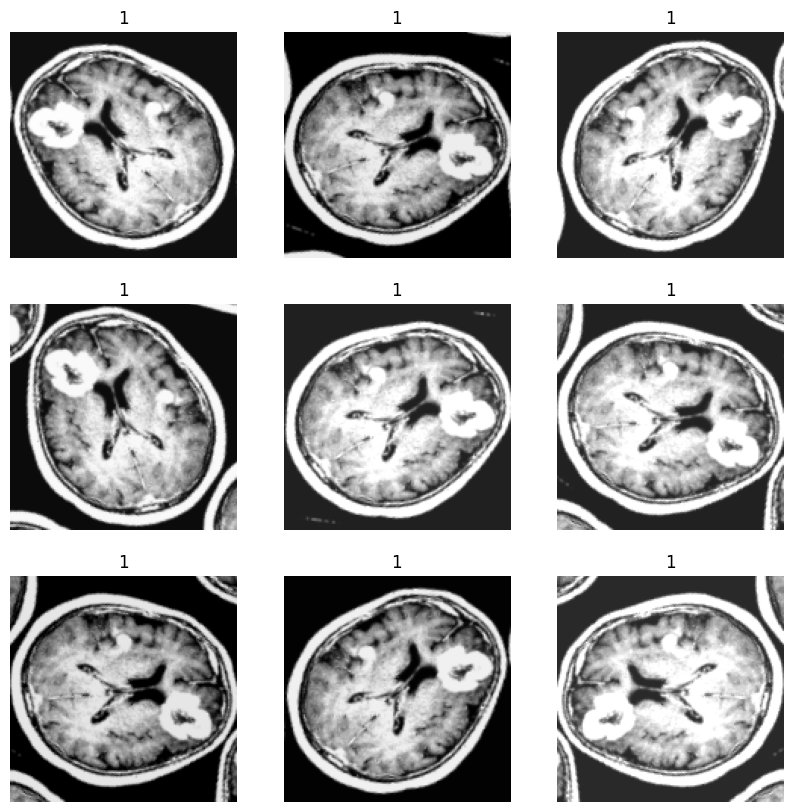

In [32]:
# Definieren von Augmentierungsschichten, die auf die Bilder angewendet werden
augmentation_layers = [
    layers.RandomFlip("horizontal"),  # Zufällige horizontale Spiegelung der Bilder
    layers.RandomRotation(0.1),  # Zufällige Rotation der Bilder um einen maximalen Winkel von 0.1 Radiant
    layers.RandomBrightness(factor=0.1)  # Zufällige Änderung der Helligkeit der Bilder mit einem Faktor von 0.1
]

# Funktion zur Anwendung der Augmentierungsschichten auf ein Bild
def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

# Anwenden der Daten-Augmentierung auf den Trainingsdatensatz
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# Iterieren über den ersten Batch im Trainingsdatensatz
for images, labels in train_ds.take(1):
    # Erstellen einer neuen Abbildung mit einer Größe von 10x10 Zoll
    plt.figure(figsize=(10, 10))
    
    # Extrahieren des ersten Bildes im Batch
    first_image = images[0]
    
    # Iterieren über die ersten 9 augmentierten Versionen des ersten Bildes
    for i in range(9):
        # Erstellen eines neuen Subplots im 3x3-Raster
        ax = plt.subplot(3, 3, i + 1)
        
        # Anwenden der Daten-Augmentierung auf das erste Bild und Darstellen des augmentierten Bildes
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        
        # Festlegen des Titels auf das Label des ersten Bildes
        plt.title(int(labels[0]))
        
        # Ausschalten der Achsenbeschriftungen
        plt.axis("off")


## Build and train a first model (Xception)

Dieser Code erstellt ein Bildklassifizierungsmodell basierend auf der Xception-Architektur und dem Transfer Learning Ansatz. Das vortrainierte Xception-Modell von ImageNet wird geladen, wobei die Eingabegröße auf 150x150 Pixel mit 3 Farbkanälen festgelegt ist und die vollständige Klassifizierungsschicht von ImageNet nicht einbezogen wird. Der Xception-Modellcode lädt ein vortrainiertes Xception-Modell mit ImageNet-Gewichten, friert die Basis des Modells ein und erstellt ein neues Modell darüber. Die Eingaben werden skaliert, und das Basis-Modell wird im Inferenzmodus verwendet, um sicherzustellen, dass Batch-Normalisierungsschichten nicht aktualisiert werden. Anschließend werden globale Durchschnittspooling, Dropout und eine Dense-Ausgabeschicht hinzugefügt, um die Klassen zu klassifizieren. Das Modell wird mit dem Adam-Optimierer und der Verlustfunktion "sparse_categorical_crossentropy" kompiliert und für eine festgelegte Anzahl von Epochen trainiert, wobei die Leistung mit Validierungsdaten überwacht wird.

- base_model ist ein vortrainiertes Modell namens Xception. Es wurde bereits auf einem großen Datensatz (ImageNet) trainiert, der viele verschiedene Bilder enthält. Wir laden dieses Modell, aber ohne den letzten Teil (den Klassifikator), weil wir es für unsere eigenen Kategorien verwenden möchten.
- base_model.trainable = False bedeutet, dass wir das vortrainierte Modell nicht weiter trainieren. Wir behalten das, was es schon gelernt hat.
- inputs ist der Eingang für unser neues Modell. Es sagt, dass wir Bilder mit einer Größe von 150x150 Pixeln und 3 Farbkanälen (RGB) verwenden.
- scale_layer skaliert die Bilder so, dass ihre Werte von -1 bis 1 reichen. Dies ist nötig, weil das vortrainierte Xception-Modell dies erwartet.
- Wir verwenden das vortrainierte Modell, um Merkmale aus den skalierten Bildern zu extrahieren.
- GlobalAveragePooling2D fasst die Informationen aus den Merkmalen zusammen.
- Dropout hilft, das Modell zu regulieren, indem es zufällig einige Verbindungen während des Trainings deaktiviert. Dies verhindert Überanpassung.
- Dense ist die letzte Schicht, die die Bilder in unsere spezifischen Kategorien einteilt. In deinem Fall gibt es zwei Klassen, also wird das Modell lernen, ob ein Bild einen Tumor hat oder nicht.
- Wir erstellen das komplette Modell mit den Eingaben und Ausgaben.
- model.summary(show_trainable=True) zeigt eine Übersicht des Modells. Es sagt uns, welche Schichten trainierbar sind und wie viele Parameter jede Schicht hat.

- optimizer=keras.optimizers.Adam(): Das ist wie ein Lehrer, der das Modell beim Lernen anleitet. Der Adam-Optimierer hilft dem Modell, die besten Antworten zu finden.
- loss="sparse_categorical_crossentropy": Das ist wie die Punktzahl, die das Modell erhält, wenn es Fehler macht. Je niedriger die Punktzahl, desto besser. Es hilft dem Modell zu wissen, wie weit es von der richtigen Antwort entfernt ist.
- metrics=['accuracy']: Das ist wie eine Liste der Noten, die wir verfolgen. In diesem Fall schauen wir uns die Genauigkeit (accuracy) an, also wie oft das Modell richtig liegt.
- initial_epochs = 4: Das sind die Trainingsrunden. Das Modell wird 4 Runden (Epochs) lang trainiert.
- model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds): Diese Zeile startet das Training des Modells:
- train_ds: Das sind die Bilder, mit denen das Modell trainiert wird.
- epochs=4: Das Modell wird 4 Runden trainiert.
- validation_data=validation_ds: Das sind die Bilder, mit denen das Modell nach jeder Runde getestet wird, um zu sehen, wie gut es lern

In [33]:
# Laden des Xception-Modells mit vorab trainierten Gewichten aus ImageNet und Einfrieren der Basis
base_model = keras.applications.Xception(
    weights="imagenet", 
    input_shape=(150, 150, 3),
    include_top=False,
)
base_model.trainable = False

# Erstellen eines neuen Modells (on top) auf Basis des Xception-Modells
inputs = keras.Input(shape=(150, 150, 3))
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# Modellzusammenfassung anzeigen
model.summary(show_trainable=True)

# Kompilieren des Modells mit dem Adam-Optimizer und sparse categorical crossentropy mit neuen Daten
model.compile(optimizer=keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

# Anzahl der anfänglichen Epochen festlegen
initial_epochs = 4

# Modelltraining mit Trainings- und Validierungsdaten durchführen
print("Training des Xception Modells beginnt...")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)
print("Training des Xception Modells abgeschlossen!")



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_9 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_2 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_4  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 2)             │      4,098 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,865,578 (79.60 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

Training des Xception Modells beginnt...
Epoch 1/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 690ms/step - accuracy: 0.7272 - loss: 0.5253 - val_accuracy: 0.8558 - val_loss: 0.3164
Epoch 2/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 733ms/step - accuracy: 0.8822 - loss: 0.3138 - val_accuracy: 0.9071 - val_loss: 0.2286
Epoch 3/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 803ms/step - accuracy: 0.9071 - loss: 0.2512 - val_accuracy: 0.9135 - val_loss: 0.2250
Epoch 4/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 764ms/step - accuracy: 0.9000 - loss: 0.2480 - val_accuracy: 0.9199 - val_loss: 0.2162
Training des Xception Modells abgeschlossen!


## Build and train a second model (VGG16)

Dieser Code erstellt ein zweites Bildklassifizierungsmodell basierend auf der VGG16-Architektur und dem Transfer Learning Ansatz. Das vortrainierte VGG16-Modell von ImageNet wird geladen, wobei die Eingabegröße auf 150x150 Pixel mit 3 Farbkanälen festgelegt ist und die vollständige Klassifizierungsschicht von ImageNet nicht einbezogen wird. Der VGG16-Modellcode lädt ein vortrainiertes VGG16-Modell mit ImageNet-Gewichten und friert es ein. Ein neues Modell wird erstellt, das VGG16 als Basis verwendet, gefolgt von globalem Durchschnittspooling, Dropout und einer Dense-Ausgabeschicht zur Klassifizierung. Das Modell wird dann mit dem Adam-Optimierer und der Verlustfunktion "sparse_categorical_crossentropy" kompiliert und für die festgelegte Anzahl von Epochen trainiert, wobei die Leistung anhand von Validierungsdaten überwacht wird.

In [34]:
# VGG16-Modell laden
vgg16_model = keras.applications.VGG16(
     weights="imagenet",  # Verwenden der vortrainierten Gewichte auf dem ImageNet-Datensatz
    input_shape=(150, 150, 3),  # Festlegen der Eingabegröße auf 150x150 Pixel mit 3 Farbkanälen
    include_top=False  # Das vollständige Klassifizierungsmodell von ImageNet nicht einbeziehen.
)

# VGG16-Modell einfrieren
vgg16_model.trainable = False  

# Neues Modell mit VGG16 als Basis erstellen
inputs = keras.Input(shape=(150, 150, 3))
x = scale_layer(inputs)
x = vgg16_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
vgg16_model = keras.Model(inputs, outputs)

# VGG16-Modell kompilieren
vgg16_model.compile(optimizer=keras.optimizers.Adam(),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy'])

# VGG16-Modell trainieren                  
print("Training des VGG16-Modells beginnt...")
vgg16_history = vgg16_model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)
print("Training des VGG16-Modells abgeschlossen!")


Training des VGG16-Modells beginnt...
Epoch 1/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6344 - loss: 0.6303 - val_accuracy: 0.8269 - val_loss: 0.5018
Epoch 2/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7728 - loss: 0.5047 - val_accuracy: 0.8397 - val_loss: 0.4496
Epoch 3/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.7888 - loss: 0.4728 - val_accuracy: 0.8750 - val_loss: 0.4008
Epoch 4/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8092 - loss: 0.4346 - val_accuracy: 0.8910 - val_loss: 0.3735
Training des VGG16-Modells abgeschlossen!


## Evaluate the models

DieserDer Code vergleicht die Leistung zweier Modelle, Xception und VGG16, die auf einem Datensatz trainiert wurden. Die letzten Validierungsverluste und -genauigkeiten beider Modelle werden erfasst und gespeichert. Eine Funktion compare_models wird definiert, um die Ergebnisse der beiden Modelle zu vergleichen und auszugeben. Es wird überprüft, welches Modell eine höhere Validierungsgenauigkeit und einen geringeren Validierungsverlust aufweist, und entsprechende Ausgaben werden gemacht.

In [35]:
# Werte des Xception-Modells
final_val_loss_xception = history.history['val_loss'][-1]
final_val_accuracy_xception = history.history['val_accuracy'][-1]

# Werte des VGG16-Modells
final_val_loss_vgg16 = vgg16_history.history['val_loss'][-1]
final_val_accuracy_vgg16 = vgg16_history.history['val_accuracy'][-1]

# Speichern der letzten Werte in einer JSON-Datei
results = {
    "xception": {
        "final_val_loss": final_val_loss_xception,
        "final_val_accuracy": final_val_accuracy_xception
    },
    "vgg16": {
        "final_val_loss": final_val_loss_vgg16,
        "final_val_accuracy": final_val_accuracy_vgg16
    }
}

# Vergleich der Modelle
def compare_models(results):
    
    print(f"Validierungsverlust Xception: {results['xception']['final_val_loss']}")
    print(f"Validierungsgenauigkeit Xception: {results['xception']['final_val_accuracy']}")

    print(f"Validierungsverlust VGG16: {results['vgg16']['final_val_loss']}")
    print(f"Validierungsgenauigkeit VGG16: {results['vgg16']['final_val_accuracy']}")
    
    # Höhere Validierungsgenauigkeit
    if results['xception']['final_val_accuracy'] > results['vgg16']['final_val_accuracy']:
        print("\nDas Xception-Modell hat eine höhere Validierungsgenauigkeit.")
    elif results['xception']['final_val_accuracy'] < results['vgg16']['final_val_accuracy']:
        print("\nDas VGG16-Modell hat eine höhere Validierungsgenauigkeit.")
    else:
        print("\nBeide Modelle haben die gleiche Validierungsgenauigkeit.")

   # Geringerer Validierungsverlust
    if results['xception']['final_val_loss'] < results['vgg16']['final_val_loss']:
        print("Das Xception-Modell hat einen geringeren Validierungsverlust.")
    elif results['xception']['final_val_loss'] > results['vgg16']['final_val_loss']:
        print("Das VGG16-Modell hat einen geringeren Validierungsverlust.")
    else:
        print("Beide Modelle haben den gleichen Validierungsverlust.")

compare_models(results)


Validierungsverlust Xception: 0.21619488298892975
Validierungsgenauigkeit Xception: 0.9198718070983887
Validierungsverlust VGG16: 0.3735179305076599
Validierungsgenauigkeit VGG16: 0.8910256624221802

Das Xception-Modell hat eine höhere Validierungsgenauigkeit.
Das Xception-Modell hat einen geringeren Validierungsverlust.


## Historie

Der Code extrahiert die Genauigkeits- und Verlustwerte aus der Trainingshistorie eines neuronalen Netzes und erstellt dann ein Diagramm mit zwei Unterplotts. Das erste Unterplott zeigt die Trainings- und Validierungsgenauigkeit über die Epochen, während das zweite Unterplott die Trainings- und Validierungsverluste darstellt. Dies ermöglicht eine visuelle Bewertung des Modelltrainings und der Leistung. Diese Visualisierungen ermöglichen es, den Trainingsverlauf des Modells zu überwachen und zu bewerten, ob es zu Überanpassung oder Unteranpassung kommt.

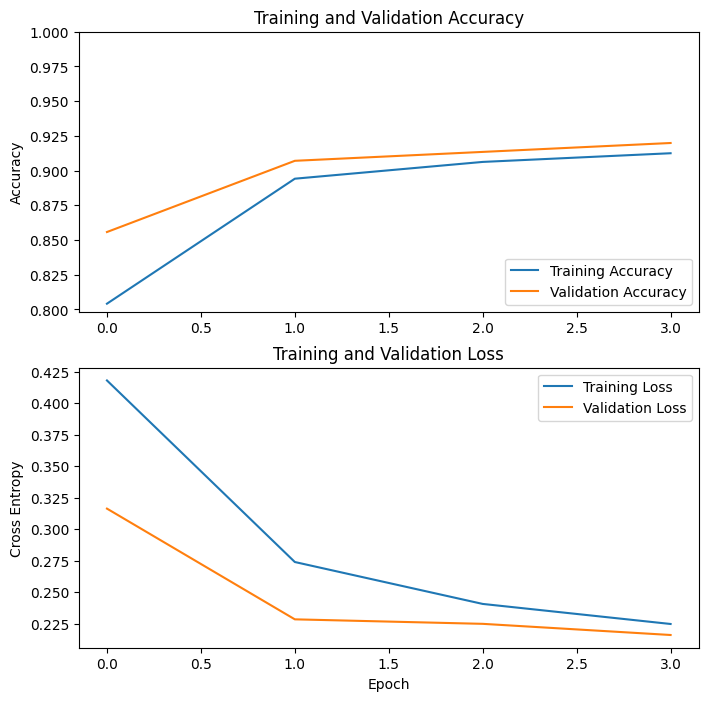

In [36]:
# Extrahieren der Genauigkeits- und Verlustwerte aus der Trainingshistorie
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Erstellen einer neuen Abbildung mit zwei Unterplotts
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)

# Plotten der Trainings- und Validierungsgenauigkeit über die Epochen
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Zweites Unterplott für Trainings- und Validierungsverluste
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


## Fine-tuning

Die Kommentare führen die Feinabstimmung eines Modells durch: Zuerst wird das Basis-Modell entsperrt, um Batchnorm-Schichten im Inferenzmodus zu erhalten. Dann wird eine Zusammenfassung des Modells mit trainierbaren Parametern angezeigt. Anschließend wird das Modell mit einer niedrigen Lernrate für die Feinabstimmung kompiliert und für eine festgelegte Anzahl von Epochen mit Validierungsdatenüberwachung trainiert.

- base_model.trainable = True: Wir erlauben dem vortrainierten Modell (das wir vorher eingefroren haben), wieder zu lernen und seine Gewichte anzupassen. Es ist so, als ob wir ein Buch wieder aufschlagen, um es weiter zu bearbeiten.
- model.summary(show_trainable=True): Zeigt eine Übersicht des Modells an und sagt uns, welche Teile des Modells jetzt trainierbar sind.
- optimizer=keras.optimizers.Adam(1e-5): Wir verwenden wieder den Adam-Optimierer, aber dieses Mal mit einer sehr niedrigen Lernrate (1e-5), was bedeutet, dass das Modell sehr kleine Schritte beim Lernen macht. Das ist so, als ob wir sehr vorsichtig schreiben, um sicherzustellen, dass wir keine Fehler machen.
- loss="sparse_categorical_crossentropy": Dies ist immer noch unsere Fehlerpunktzahl. Sie hilft dem Modell zu wissen, wie weit es von der richtigen Antwort entfernt ist.
- metrics=['accuracy']: Wir verfolgen immer noch, wie oft das Modell richtig liegt.

In [37]:
# Entsperren des base_model für Feinabstimmung im Inferenzmodus, um Batchnorm-Schichten zu erhalten.
base_model.trainable = True

# Modellzusammenfassung anzeigen, einschließlich der trainierbaren Parameter.
model.summary(show_trainable=True)

# Modell für Feinabstimmung mit niedriger Lernrate kompilieren.
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

# Festlegen der Anzahl von Feinabstimmungs-Epochen.
epochs = 4

# Ausführen des Trainings des gesamten Modells für die angegebene Anzahl von Epochen mit Validierungsdatenüberwachung.
print("Feinabstimmung beginnt...")
history_fine = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)
print("Feinabstimmung abgeschlossen!")

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_9 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_2 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_4  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 2)             │      4,098 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,873,776 (79.63 MB)

 Trainable params: 20,811,050 (79.39 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 8,198 (32.03 KB)

Feinabstimmung beginnt...
Epoch 1/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.7517 - loss: 0.5239 - val_accuracy: 0.8942 - val_loss: 0.2454
Epoch 2/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.8999 - loss: 0.2877 - val_accuracy: 0.9295 - val_loss: 0.1964
Epoch 3/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.9293 - loss: 0.1936 - val_accuracy: 0.9455 - val_loss: 0.1508
Epoch 4/4
75/75 ━━━━━━━━━━━━━━━━━━━━ 286s 4s/step - accuracy: 0.9461 - loss: 0.1536 - val_accuracy: 0.9551 - val_loss: 0.1239
Feinabstimmung abgeschlossen!



Die Genauigkeits- und Verlustwerte der Feinabstimmung werden zum ursprünglichen Verlauf hinzugefügt. Anschließend wird ein Diagramm mit zwei Unterplotts erstellt: Das erste zeigt kombinierte Trainings- und Validierungsgenauigkeiten mit einer vertikalen Linie, die den Startpunkt der Feinabstimmung markiert; das zweite zeigt kombinierte Trainings- und Validierungsverluste auf ähnliche Weise.

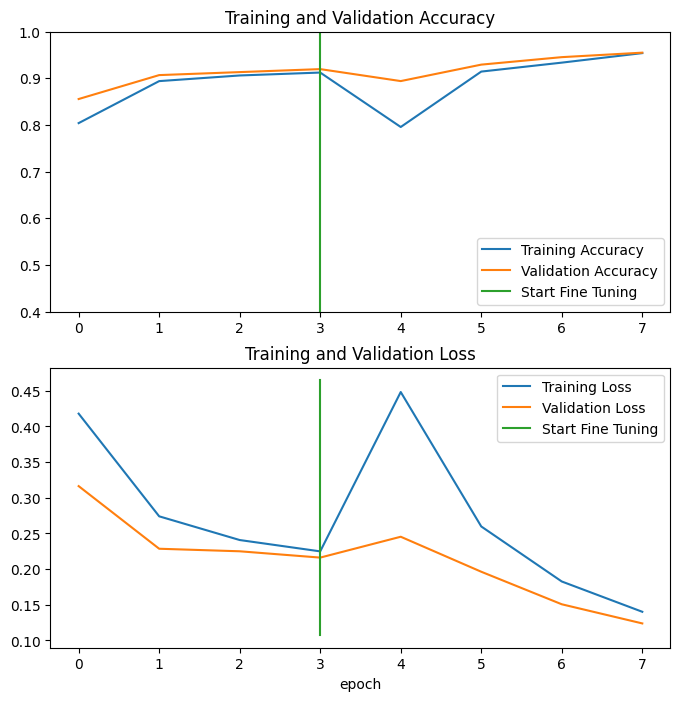

In [38]:
# Hinzufügen der Genauigkeits- und Verlustwerte aus der Feinabstimmung zum ursprünglichen Verlauf
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# Erstellen einer neuen Abbildung mit zwei Unterplotts
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)

# Plotten der kombinierten Trainings- und Validierungsgenauigkeit mit einer vertikalen Linie, die den Startpunkt der Feinabstimmung markiert
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])  # Festlegen der y-Achsenbegrenzung
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)

# Plotten der kombinierten Trainings- und Validierungsverluste mit einer vertikalen Linie, die den Startpunkt der Feinabstimmung markiert
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Dieser Code bewertet das Modell anhand des Testdatensatzes und gibt die Verlustfunktion sowie die Genauigkeit aus.

In [39]:
print("Testdatensatzbewertung")

# Evaluierung des Modells anhand des Testdatensatzes und Ausgabe der Verlustfunktion und der Genauigkeit.
model.evaluate(test_ds)


Testdatensatzbewertung
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 690ms/step - accuracy: 0.9772 - loss: 0.0936


[0.09566103667020798, 0.9756944179534912]

Der Code ruft einen Batch von Bildern aus dem Testdatensatz ab und führt Vorhersagen mit dem Modell durch. Diese Vorhersagen werden dann in Wahrscheinlichkeiten umgewandelt und mit den tatsächlichen Labels verglichen. Anschließend werden die Bilder mit ihren Vorhersagen, den tatsächlichen Labels und den Vorhersageprozenten geplottet.

- image_batch: Eine Gruppe von Bildern aus dem Testdatensatz.
- label_batch: Die tatsächlichen Labels (z.B. Tumor oder Nicht-Tumor) dieser Testbilder.

- np.argmax: Wählt die Klasse mit der höchsten Wahrscheinlichkeit als Vorhersage des Modells.

Vorhersagen:
 [0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0]
Labels:
 [0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0]


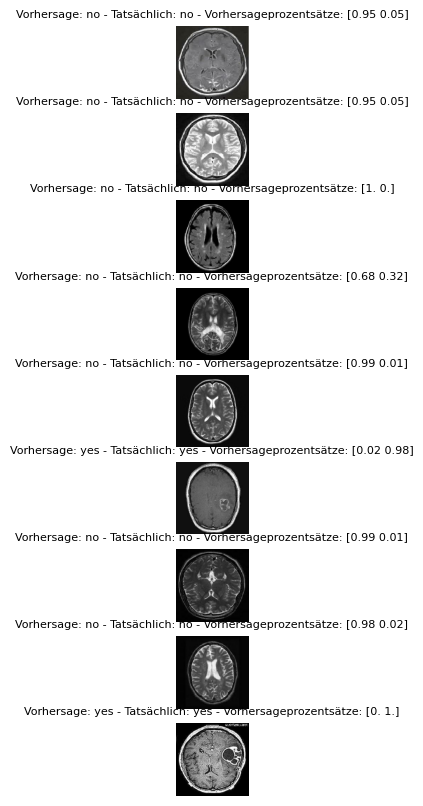

In [40]:
# Abrufen eines Batches von Bildern aus dem Testdatensatz
image_batch, label_batch = test_ds.as_numpy_iterator().next()

# Vorhersagen für den Batch von Bildern mithilfe des Modells
predictions_in_percentage = model.predict_on_batch(image_batch)

# Da unser Modell Logits zurückgibt, wenden wir eine Sigmoid-Funktion an, um Wahrscheinlichkeiten zu erhalten
# Vorhersagen in Wahrscheinlichkeiten umwandeln
predictions = np.argmax(predictions_in_percentage, axis=-1)

# Ausgabe der Vorhersagen und der tatsächlichen Labels
print('Vorhersagen:\n', predictions)
print('Labels:\n', label_batch)

# Plotten der Bilder mit ihren Vorhersagen und tatsächlichen Labels
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(9, 1, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    # Titel für jedes Bild anzeigen, einschließlich der Vorhersage, des tatsächlichen Labels und der Vorhersageprozentsätze
    plt.title('Vorhersage: ' + class_names[predictions[i]] + ' - Tatsächlich: ' + class_names[label_batch[i]] + ' - Vorhersageprozentsätze: ' + str(np.round(predictions_in_percentage[i], 2)), fontsize=8)
    plt.axis("off")


## Model abspeichern


Das Modell wird als Datei mit dem Namen 'brain_tumor.keras' gespeichert, und eine Bestätigung wird ausgegeben, um anzuzeigen, dass der Speichervorgang erfolgreich war.

In [41]:
model.save('brain_tumor.keras')
print("Das Modell wurde erfolgreich unter dem Namen 'brain_tumor.keras' gespeichert.")

Das Modell wurde erfolgreich unter dem Namen 'brain_tumor.keras' gespeichert.
